# 프로젝트 : 주식 예측에 도전해 보자
이제 실제 주식값 예측에 도전해 보자. 데이터는 과거의 일자별 시세이며, 다음의 그림과 같이 Yahoo Finance에서 다운로드할 수 있다.
https://finance.yahoo.com/

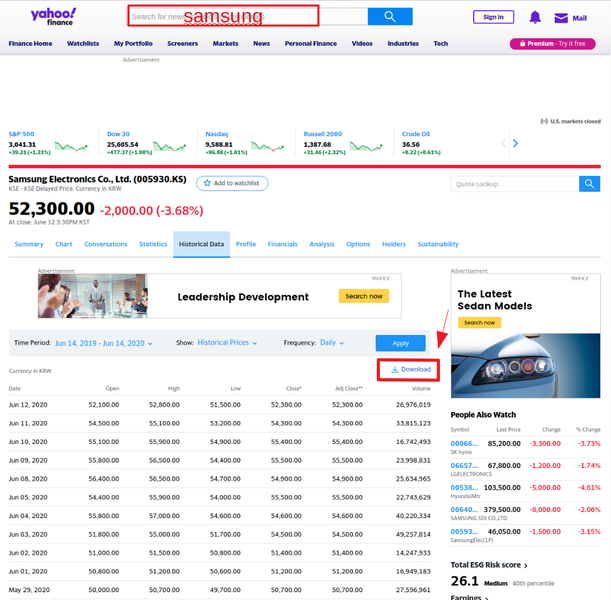

```
$ mkdir -p ~/aiffel/stock_prediction/data
$ mv ~/다운로드/005930.KS.csv ~/aiffel/stock_prediction/data
# 환경설정을 영어로 사용하는 경우는 아래 명령어를 입력하세요.
$ mv ~/Downloads/005930.KS.csv ~/aiffel/stock_prediction/data

```

# STEP 1 : 시계열 데이터 준비(삼성)
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용할 것이다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격이다.)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-03-02    55000.0
2020-03-03    55400.0
2020-03-04    57400.0
2020-03-05    57800.0
2020-03-06    56500.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [48]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [49]:
# 로그 변환 시도 
ts_log = np.log(ts)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

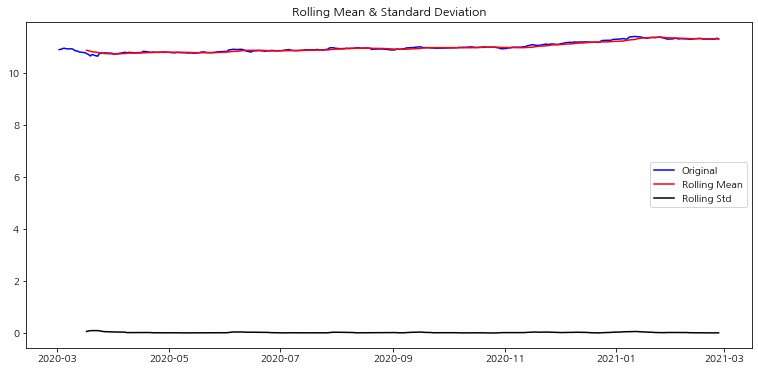

Results of Dickey-Fuller Test:
Test Statistic                  -0.138318
p-value                          0.945486
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


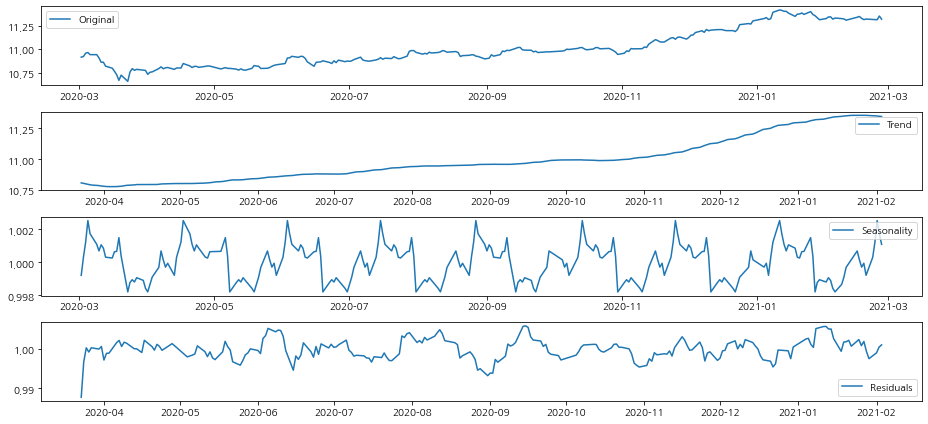

In [50]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [51]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.577129e+00
p-value                        7.675481e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

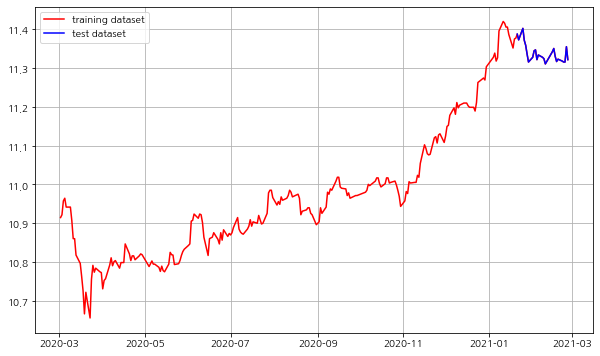

In [52]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


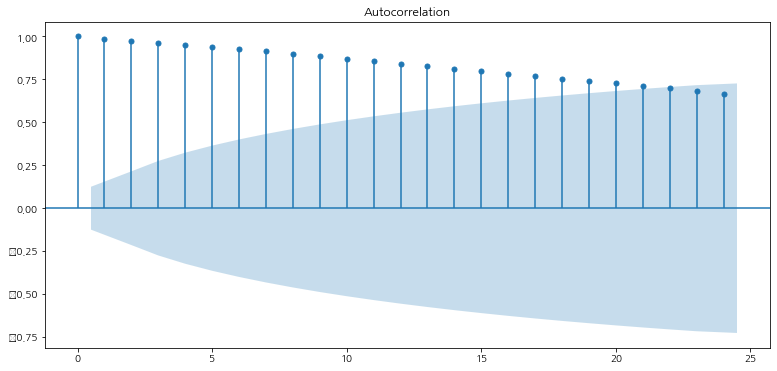

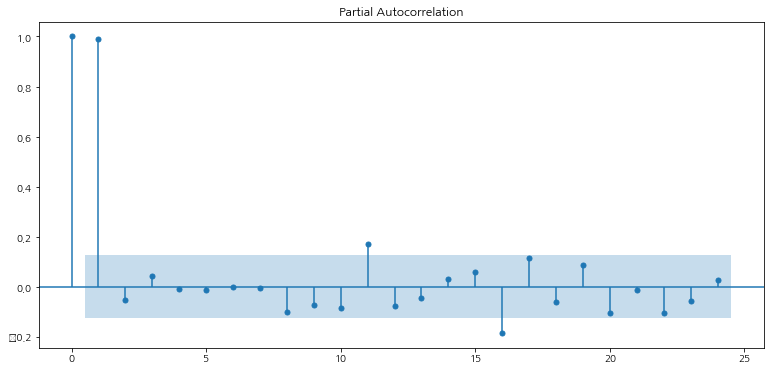

In [53]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.605903e+01
p-value                        5.665557e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


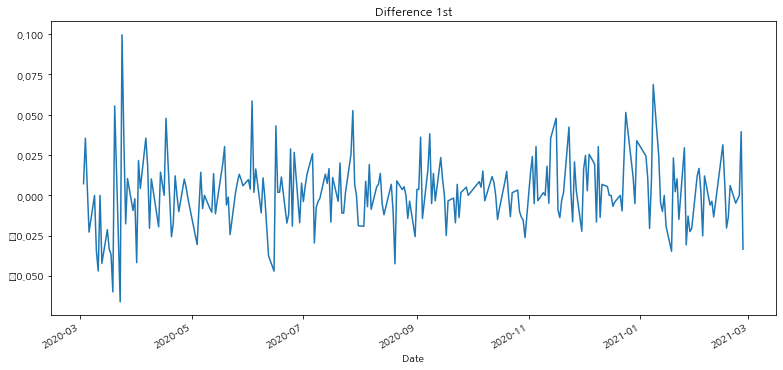

In [54]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.958644e+00
p-value                        9.287130e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


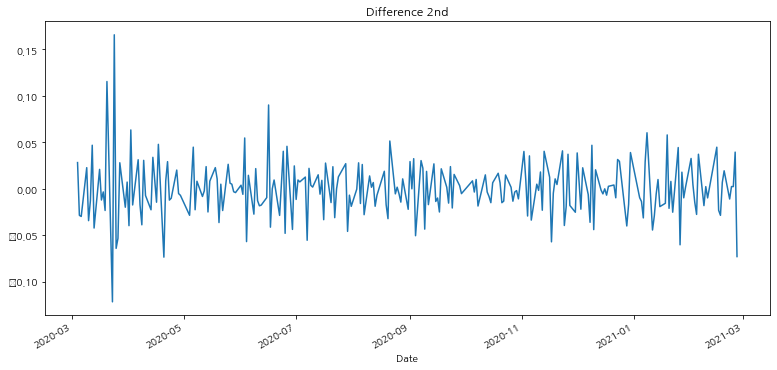

In [55]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [56]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  220
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 532.334
Method:                       css-mle   S.D. of innovations              0.022
Date:                Mon, 01 Mar 2021   AIC                          -1058.667
Time:                        01:49:26   BIC                          -1048.486
Sample:                             1   HQIC                         -1054.556
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0021      0.001      1.474      0.141      -0.001       0.005
ar.L1.D.Close    -0.0210      0.067     -0.312      0.755      -0.153       0.111
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

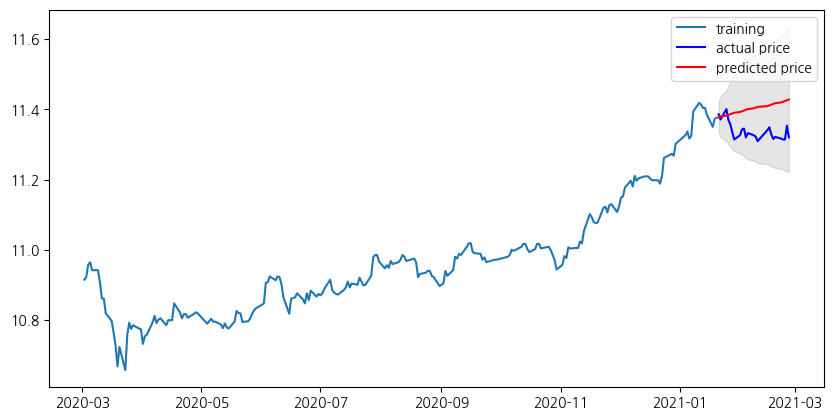

In [57]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  41618901.981692016
MAE:  5862.097295866904
RMSE:  6451.271346152789
MAPE: 7.06%


# STEP 7 : 다른 주식 종목 예측해 보기

## 주식종목
```
HMM Co.,Ltd    : 한국의 해운업체         011200.KS.csv 
TSLA           : 자동차 제조 및 판매업    TSLA.csv
 Alphabet Inc.  : 구글 모회사           GOOG.csv
```
```
야후에서 다운로드후 파일 이동
$ mv ~/Downloads/011200.KS.csv ~/aiffel/stock_prediction/data
$ mv ~/Downloads/TSLA.csv ~/aiffel/stock_prediction/data
$ mv ~/Downloads/GOOG.csv ~/aiffel/stock_prediction/data
$ mv ~/Downloads/011200.KS\(1\).csv ~/aiffel/stock_prediction/data   상장시작부터 현재까지

```

https://finance.yahoo.com/quote/TSLA/history?p=TSLA
https://finance.yahoo.com/quote/011200.KS?ltr=1

# STEP 1 : 시계열 데이터 준비(테슬라, HMM 1년치)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset01_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/011200.KS.csv'
dataset02_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'


df01 = pd.read_csv(dataset01_filepath, index_col='Date', parse_dates=True)
ts01 = df01['Close']

df02 = pd.read_csv(dataset02_filepath, index_col='Date', parse_dates=True)
ts02 = df02['Close']

In [9]:
# HMM
ts01.head()

Date
2020-03-03    3405.0
2020-03-04    3525.0
2020-03-05    3730.0
2020-03-06    3670.0
2020-03-09    3670.0
Name: Close, dtype: float64

In [10]:
# 테슬라
ts02.head()

Date
2020-03-03    149.102005
2020-03-04    149.899994
2020-03-05    144.908005
2020-03-06    140.695999
2020-03-09    121.599998
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

## 결측치 처리

In [11]:
# 결측치 처리
ts01=ts01.interpolate(method='time')
ts02=ts02.interpolate(method='time')

In [12]:
# HMM
ts01[ts01.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [13]:
#테슬라
ts02[ts02.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

## 로그 변환 

In [14]:
# 로그 변환 시도 
ts01_log = np.log(ts01)
ts02_log = np.log(ts02)

# STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

## statsmodels 패키지와 adfuller 메소드
statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지입니다. 이번 노드에서는 statsmodels 패키지의 기능을 자주 활용하게 될 것입니다. 아래는 statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드입니다.

아래 코드를 수행하기 위해 먼저 다음과 같이 statsmodels 패키지를 설치합니다.

$ pip install statsmodels

In [18]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [19]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


## HMM에 대한 시계열 안정성 분석

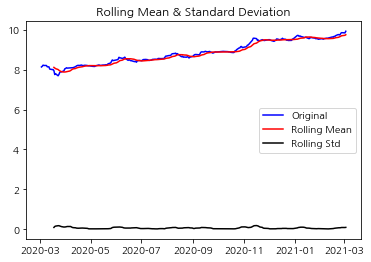

Results of Dickey-Fuller Test:
Test Statistic                   0.018680
p-value                          0.960050
#Lags Used                       3.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


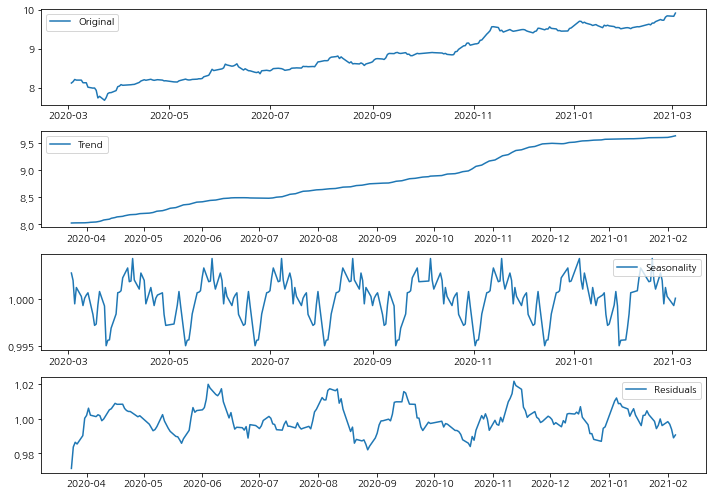

In [26]:
# 정성적 그래프 분석
plot_rolling_statistics(ts01_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts01_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition01 = seasonal_decompose(ts01_log, model='multiplicative', period = 30) 

trend01 = decomposition01.trend
seasonal01 = decomposition01.seasonal
residual01 = decomposition01.resid

plt.figure(figsize=(10,7))
plt.subplot(411)
plt.plot(ts01_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend01, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal01,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual01, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## 테슬라에 대한 시계열 안정성 분석¶

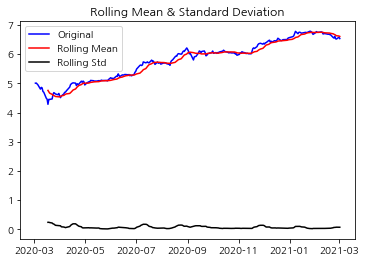

Results of Dickey-Fuller Test:
Test Statistic                  -0.677590
p-value                          0.852469
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


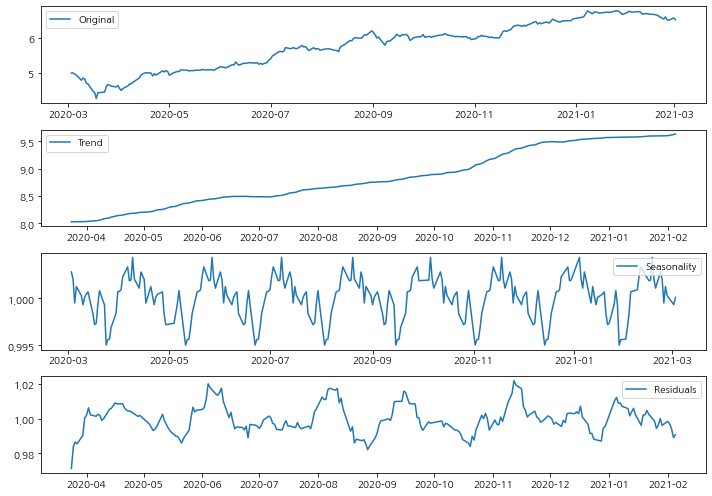

In [27]:
# 정성적 그래프 분석
plot_rolling_statistics(ts02_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts02_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition02 = seasonal_decompose(ts02_log, model='multiplicative', period = 30) 

trend02 = decomposition01.trend
seasonal02 = decomposition01.seasonal
residual02 = decomposition01.resid

plt.figure(figsize=(10,7))
plt.subplot(411)
plt.plot(ts02_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend02, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal02,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual02, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# STEP 4 : 학습, 테스트 데이터셋 생성
학습, 테스트 데이터셋 분리

## HMM 테스트 데이터셋 생성

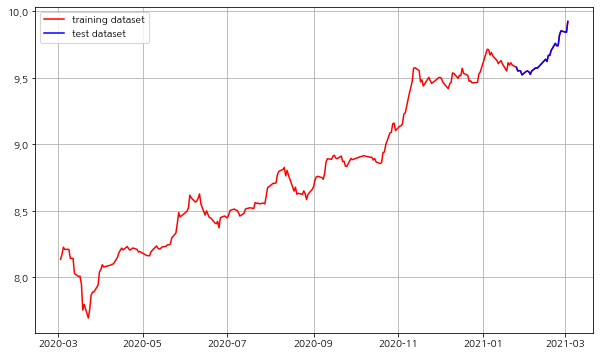

In [30]:
train01_data, test01_data = ts01_log[:int(len(ts01_log)*0.9)], ts01_log[int(len(ts01_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts01_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test01_data, c='b', label='test dataset')
plt.legend()

## 테슬라 테스트 데이터셋 생성

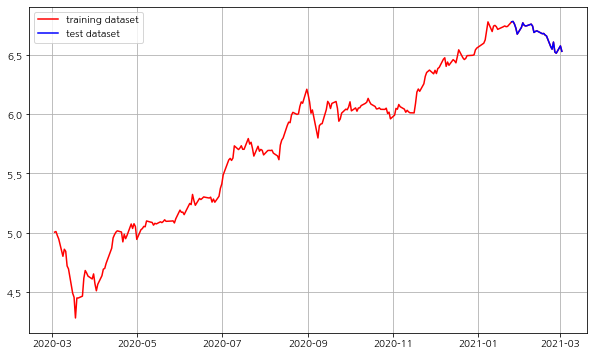

In [31]:
train02_data, test02_data = ts02_log[:int(len(ts02_log)*0.9)], ts02_log[int(len(ts02_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts02_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test02_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기

## HMM 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


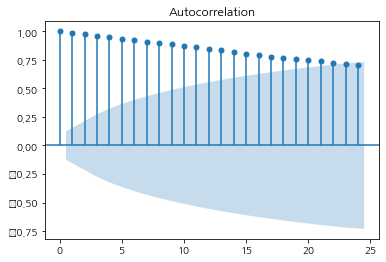

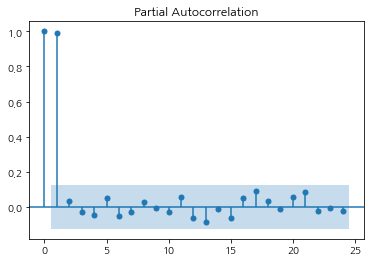

In [33]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts01_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts01_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.878667e+00
p-value                        1.452335e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


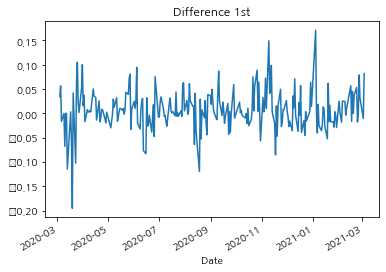

In [35]:
# 1차 차분 구하기
diff01_1 = ts01_log.diff(periods=1).iloc[1:]
diff01_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff01_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.357547e+00
p-value                        2.881801e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


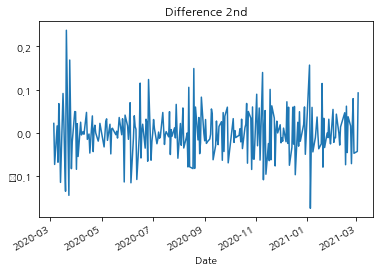

In [36]:
# 혹시 필요한 경우 2차 차분 구하기
diff01_2 = diff01_1.diff(periods=1).iloc[1:]
diff01_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff01_2)

## 테슬라 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


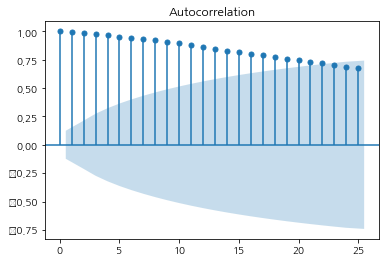

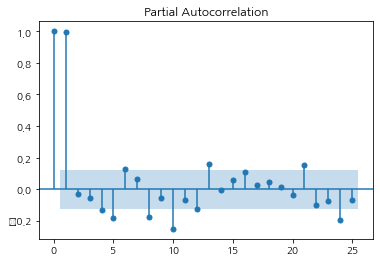

In [34]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts02_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts02_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.612415e+01
p-value                        4.862162e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


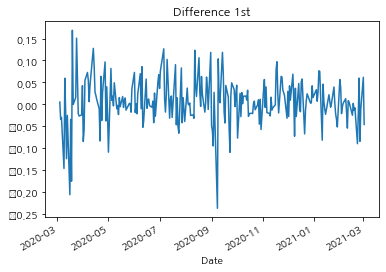

In [37]:
# 1차 차분 구하기
diff02_1 = ts02_log.diff(periods=1).iloc[1:]
diff02_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff02_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.735889e+00
p-value                        3.208440e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


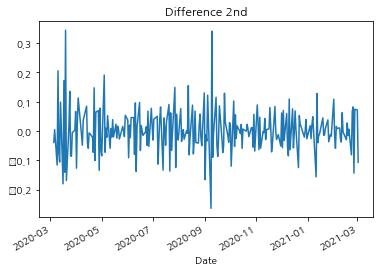

In [38]:
# 혹시 필요한 경우 2차 차분 구하기
diff02_2 = diff02_1.diff(periods=1).iloc[1:]
diff02_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff02_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

## HMM 훈련과 테스트

In [40]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model01 = ARIMA(train01_data, order=(1, 1, 0))  
fitted01_m = model01.fit(disp=-1)  
print(fitted01_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 390.079
Method:                       css-mle   S.D. of innovations              0.041
Date:                Wed, 03 Mar 2021   AIC                           -774.158
Time:                        20:01:59   BIC                           -763.963
Sample:                             1   HQIC                          -770.041
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0066      0.003      2.135      0.033       0.001       0.013
ar.L1.D.Close     0.1020      0.067      1.526      0.127      -0.029       0.233
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


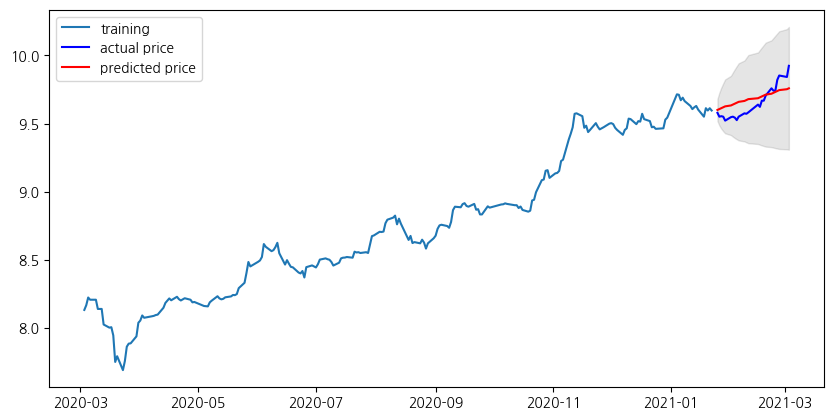

In [42]:
# Forecast : 결과가 fc에 담깁니다. 
fc01, se01, conf01 = fitted01_m.forecast(len(test01_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc01_series = pd.Series(fc01, index=test01_data.index)   # 예측결과
lower01_series = pd.Series(conf01[:, 0], index=test01_data.index)  # 예측결과의 하한 바운드
upper01_series = pd.Series(conf01[:, 1], index=test01_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train01_data, label='training')
plt.plot(test01_data, c='b', label='actual price')
plt.plot(fc01_series, c='r',label='predicted price')
plt.fill_between(lower01_series.index, lower01_series, upper01_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse01 = mean_squared_error(np.exp(test01_data), np.exp(fc01))
print('MSE: ', mse01)

mae01 = mean_absolute_error(np.exp(test01_data), np.exp(fc01))
print('MAE: ', mae01)

rmse01 = math.sqrt(mean_squared_error(np.exp(test01_data), np.exp(fc01)))
print('RMSE: ', rmse01)

mape01 = np.mean(np.abs(np.exp(fc01) - np.exp(test01_data))/np.abs(np.exp(test01_data)))
print('MAPE: {:.2f}%'.format(mape01*100))

MSE:  1746899.1473582855
MAE:  1144.7452947901568
RMSE:  1321.7031237605083
MAPE: 7.38%


## 테슬라 훈련과 테스트

In [47]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model02 = ARIMA(train02_data, order=(1, 1, 0))  
fitted02_m = model02.fit(disp=-1)  
print(fitted02_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 337.297
Method:                       css-mle   S.D. of innovations              0.054
Date:                Wed, 03 Mar 2021   AIC                           -668.594
Time:                        20:07:10   BIC                           -658.345
Sample:                             1   HQIC                          -664.457
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0077      0.004      2.197      0.028       0.001       0.015
ar.L1.D.Close    -0.0253      0.066     -0.381      0.703      -0.156       0.105
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

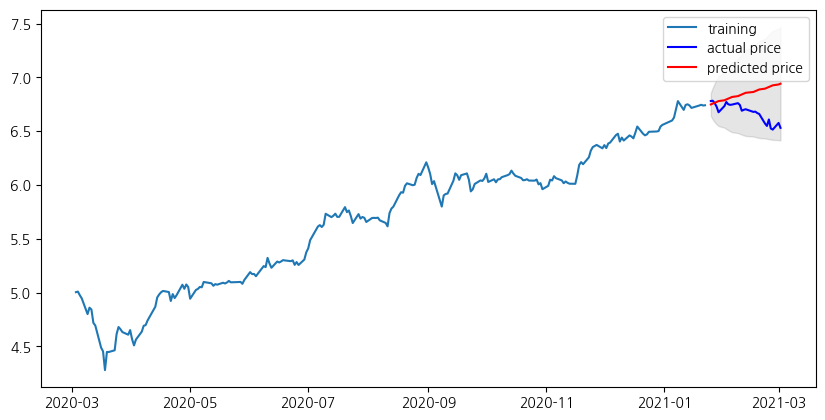

In [48]:
# Forecast : 결과가 fc에 담깁니다. 
fc02, se02, conf02 = fitted02_m.forecast(len(test02_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc02_series = pd.Series(fc02, index=test02_data.index)   # 예측결과
lower02_series = pd.Series(conf02[:, 0], index=test02_data.index)  # 예측결과의 하한 바운드
upper02_series = pd.Series(conf02[:, 1], index=test02_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train02_data, label='training')
plt.plot(test02_data, c='b', label='actual price')
plt.plot(fc02_series, c='r',label='predicted price')
plt.fill_between(lower02_series.index, lower02_series, upper02_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse02 = mean_squared_error(np.exp(test02_data), np.exp(fc02))
print('MSE: ', mse02)

mae02 = mean_absolute_error(np.exp(test02_data), np.exp(fc02))
print('MAE: ', mae02)

rmse02 = math.sqrt(mean_squared_error(np.exp(test02_data), np.exp(fc02)))
print('RMSE: ', rmse02)

mape02 = np.mean(np.abs(np.exp(fc02) - np.exp(test02_data))/np.abs(np.exp(test02_data)))
print('MAPE: {:.2f}%'.format(mape02*100))

MSE:  34132.56819502281
MAE:  147.0422205775697
RMSE:  184.75001541278098
MAPE: 19.74%


# Alphabet Inc. (GOOG) 예측하기(상장이후부터)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset03_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'


df03 = pd.read_csv(dataset03_filepath, index_col='Date', parse_dates=True)
ts03 = df03['Close']

# HMM
ts03.head()

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239197
2004-08-25    52.802086
Name: Close, dtype: float64

### 결측치 처리

In [7]:
# 결측치 처리
ts03=ts03.interpolate(method='time')

ts03[ts03.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

### 로그 변환

In [8]:
# 로그 변환 시도 
ts03_log = np.log(ts03)

### 시계열 안정성 분석

window을 365로 설정

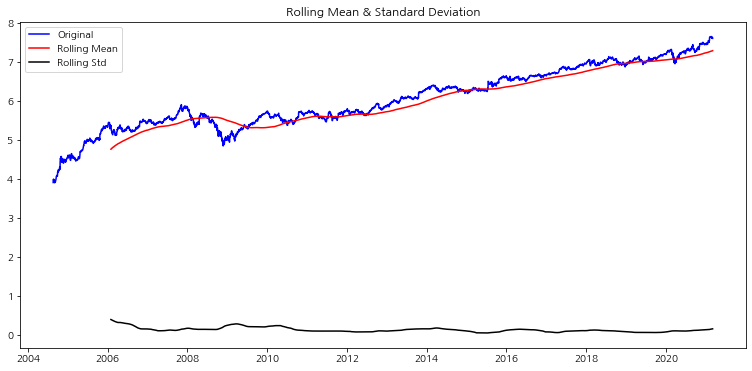

Results of Dickey-Fuller Test:
Test Statistic                   -1.895851
p-value                           0.334016
#Lags Used                        7.000000
Number of Observations Used    4155.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


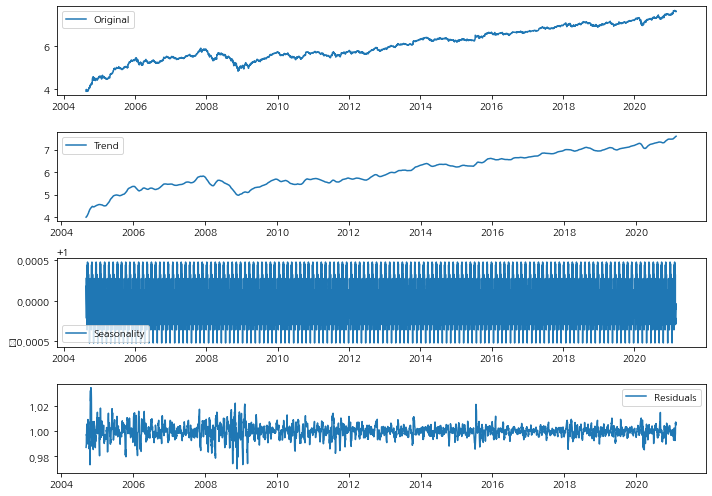

In [34]:
# 정성적 그래프 분석
plot_rolling_statistics(ts03_log, window=365
                       )

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts03_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition03 = seasonal_decompose(ts03_log, model='multiplicative', period = 30) 

trend03 = decomposition03.trend
seasonal03 = decomposition03.seasonal
residual03 = decomposition03.resid

plt.figure(figsize=(10,7))
plt.subplot(411)
plt.plot(ts03_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend03, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal03,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual03, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 학습, 테스트 데이터셋 생성

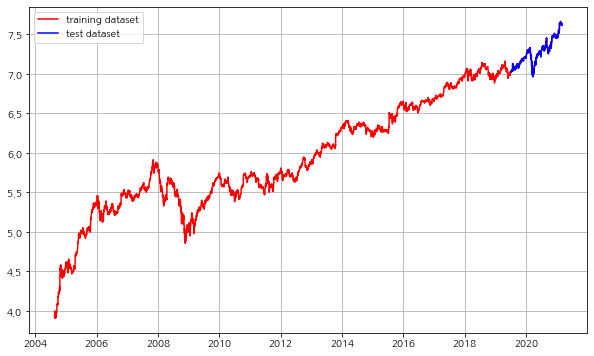

In [36]:
train03_data, test03_data = ts03_log[:int(len(ts03_log)*0.9)], ts03_log[int(len(ts03_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts03_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test03_data, c='b', label='test dataset')
plt.legend()

### 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


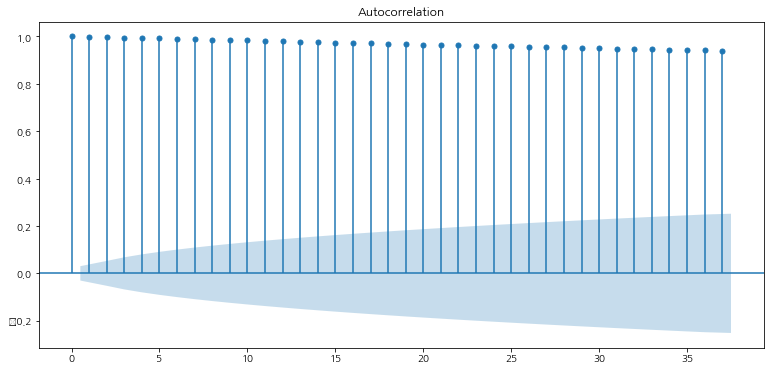

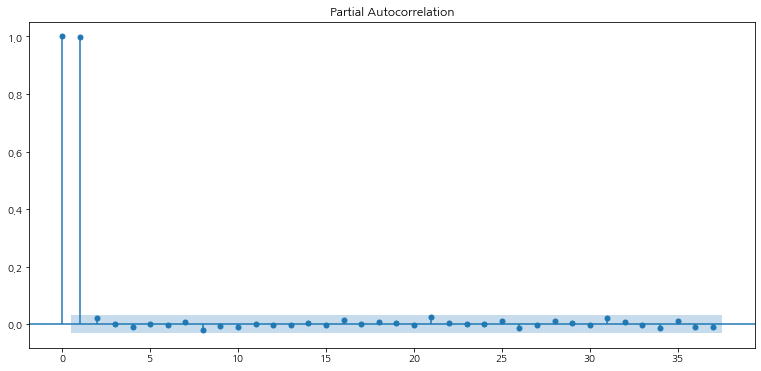

In [37]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts03_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts03_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -24.620477
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    4155.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


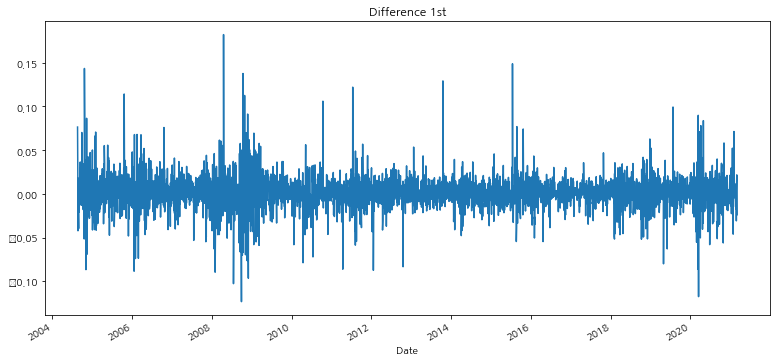

In [38]:
# 1차 차분 구하기
diff03_1 = ts03_log.diff(periods=1).iloc[1:]
diff03_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff03_1)

Results of Dickey-Fuller Test:
Test Statistic                  -20.532330
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4129.000000
Critical Value (1%)              -3.431935
Critical Value (5%)              -2.862240
Critical Value (10%)             -2.567143
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


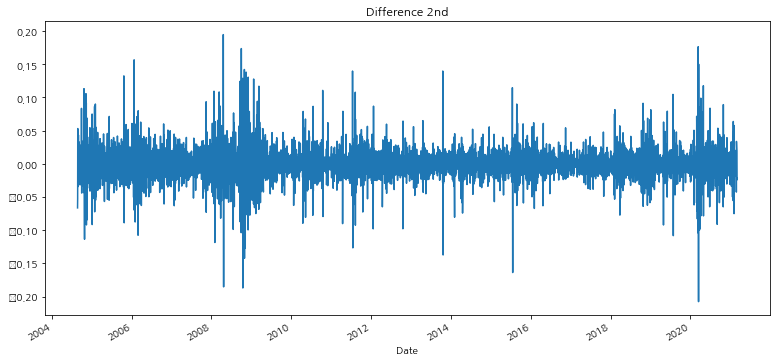

In [39]:
# 혹시 필요한 경우 2차 차분 구하기
diff03_2 = diff03_1.diff(periods=1).iloc[1:]
diff03_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff03_2)

### ARIMA 모델 훈련과 테스트

In [40]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model03 = ARIMA(train03_data, order=(1, 1, 0))  
fitted03_m = model03.fit(disp=-1)  
print(fitted03_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3745
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9551.347
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 04 Mar 2021   AIC                         -19096.693
Time:                        12:41:50   BIC                         -19078.009
Sample:                             1   HQIC                        -19090.048
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.659      0.008       0.000       0.001
ar.L1.D.Close     0.0107      0.016      0.655      0.512      -0.021       0.043
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

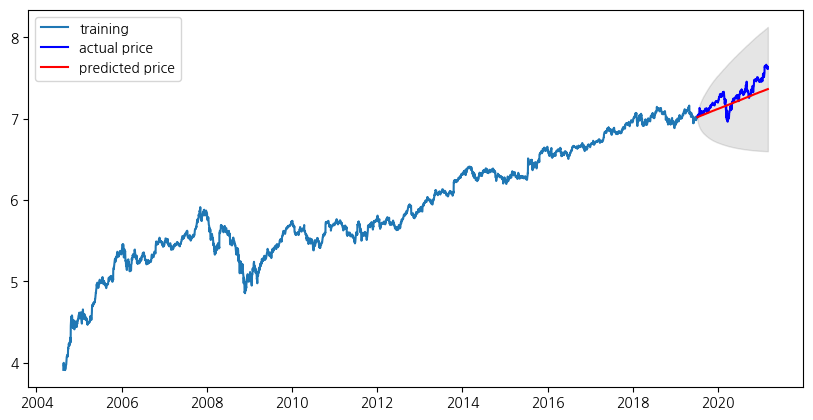

In [41]:
# Forecast : 결과가 fc에 담깁니다. 
fc03, se03, conf03 = fitted03_m.forecast(len(test03_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc03_series = pd.Series(fc03, index=test03_data.index)   # 예측결과
lower03_series = pd.Series(conf03[:, 0], index=test03_data.index)  # 예측결과의 하한 바운드
upper03_series = pd.Series(conf03[:, 1], index=test03_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train03_data, label='training')
plt.plot(test03_data, c='b', label='actual price')
plt.plot(fc03_series, c='r',label='predicted price')
plt.fill_between(lower03_series.index, lower03_series, upper03_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse03 = mean_squared_error(np.exp(test03_data), np.exp(fc03))
print('MSE: ', mse03)

mae03 = mean_absolute_error(np.exp(test03_data), np.exp(fc03))
print('MAE: ', mae03)

rmse03 = math.sqrt(mean_squared_error(np.exp(test03_data), np.exp(fc03)))
print('RMSE: ', rmse03)

mape03 = np.mean(np.abs(np.exp(fc03) - np.exp(test03_data))/np.abs(np.exp(test03_data)))
print('MAPE: {:.2f}%'.format(mape03*100))

MSE:  34945.00251539792
MAE:  143.2144549482689
RMSE:  186.9358245906812
MAPE: 9.10%


# HMM 예측하기(상징이후부터)

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset03_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/011200.KS(1).csv'

df03 = pd.read_csv(dataset03_filepath, index_col='Date', parse_dates=True)
ts03 = df03['Close']

# HMM
ts03.head()

Date
2000-01-04    41011.183594
2000-01-05    39273.867188
2000-01-06    37168.027344
2000-01-07    37694.488281
2000-01-10    37905.070313
Name: Close, dtype: float64

### 결측치 처리

In [46]:
# 결측치 처리
ts03=ts03.interpolate(method='time')

ts03[ts03.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

### 로그 변환

In [47]:
# 로그 변환 시도 
ts03_log = np.log(ts03)

### 시계열 안정성 분석

window을 365로 설정

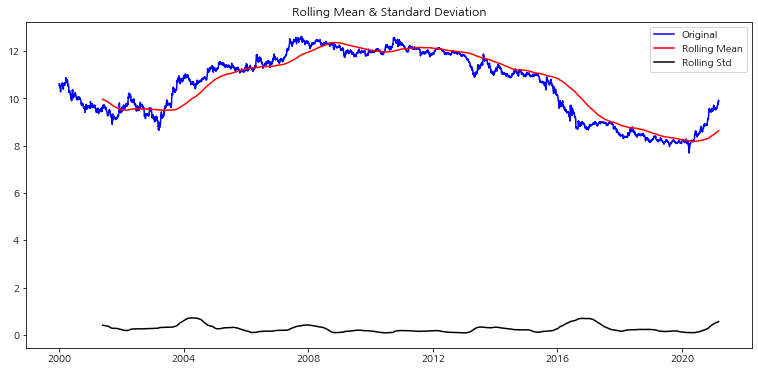

Results of Dickey-Fuller Test:
Test Statistic                   -0.970015
p-value                           0.764043
#Lags Used                        6.000000
Number of Observations Used    5314.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


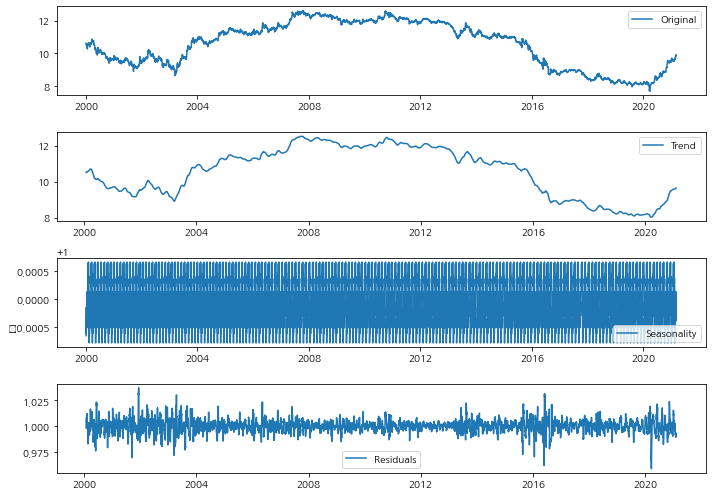

In [48]:
# 정성적 그래프 분석
plot_rolling_statistics(ts03_log, window=365
                       )

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts03_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition03 = seasonal_decompose(ts03_log, model='multiplicative', period = 30) 

trend03 = decomposition03.trend
seasonal03 = decomposition03.seasonal
residual03 = decomposition03.resid

plt.figure(figsize=(10,7))
plt.subplot(411)
plt.plot(ts03_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend03, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal03,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual03, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 학습, 테스트 데이터셋 생성

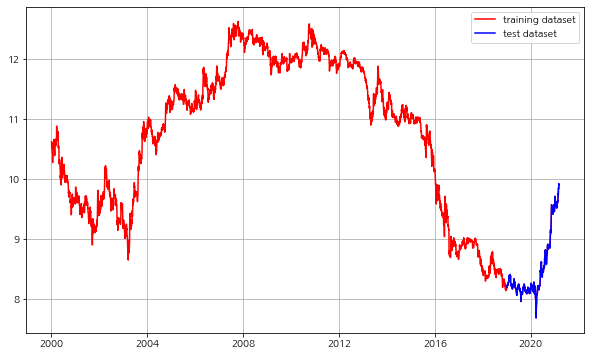

In [49]:
train03_data, test03_data = ts03_log[:int(len(ts03_log)*0.9)], ts03_log[int(len(ts03_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts03_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test03_data, c='b', label='test dataset')
plt.legend()

### 적정 ARIMA 모수 찾기

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


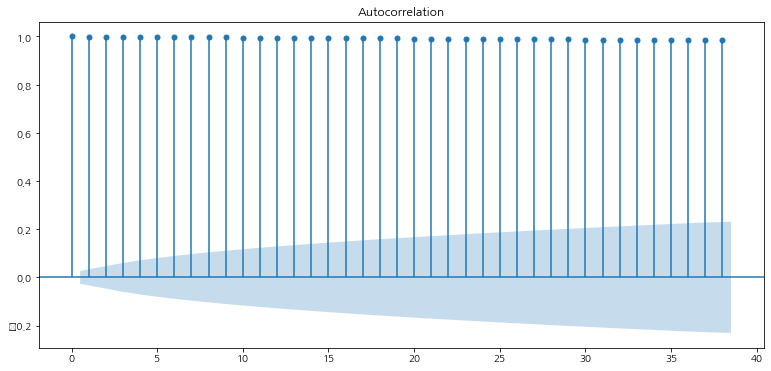

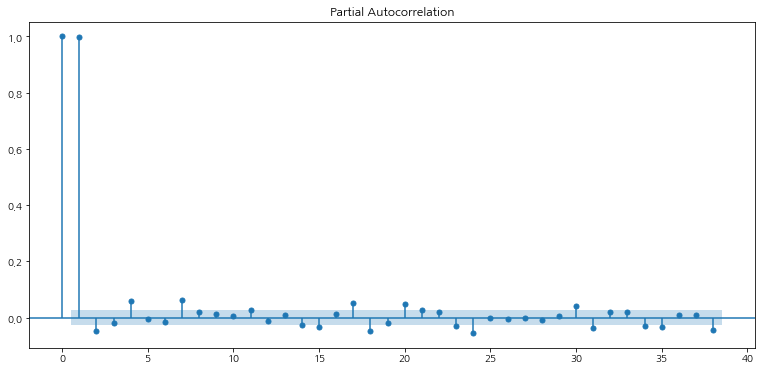

In [50]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts03_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts03_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -31.095553
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    5314.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


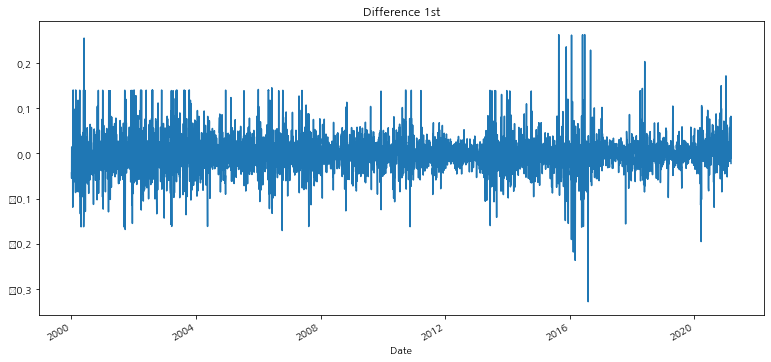

In [51]:
# 1차 차분 구하기
diff03_1 = ts03_log.diff(periods=1).iloc[1:]
diff03_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff03_1)

Results of Dickey-Fuller Test:
Test Statistic                  -22.114657
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5285.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


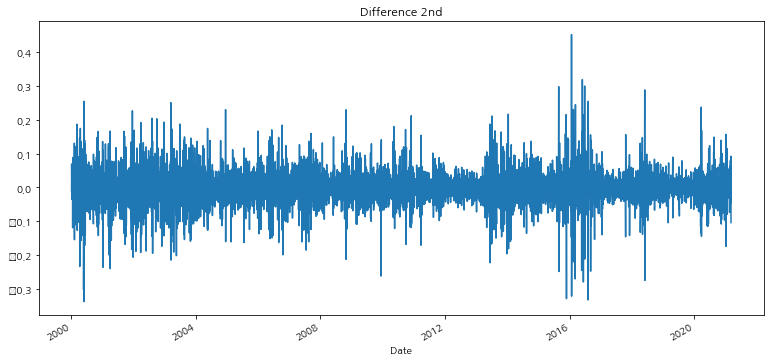

In [52]:
# 혹시 필요한 경우 2차 차분 구하기
diff03_2 = diff03_1.diff(periods=1).iloc[1:]
diff03_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff03_2)

### ARIMA 모델 훈련과 테스트

In [53]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model03 = ARIMA(train03_data, order=(1, 1, 0))  
fitted03_m = model03.fit(disp=-1)  
print(fitted03_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8565.862
Method:                       css-mle   S.D. of innovations              0.040
Date:                Thu, 04 Mar 2021   AIC                         -17125.724
Time:                        12:55:47   BIC                         -17106.303
Sample:                             1   HQIC                        -17118.903
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0005      0.001     -0.842      0.400      -0.002       0.001
ar.L1.D.Close     0.0247      0.014      1.711      0.087      -0.004       0.053
                                    Root

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

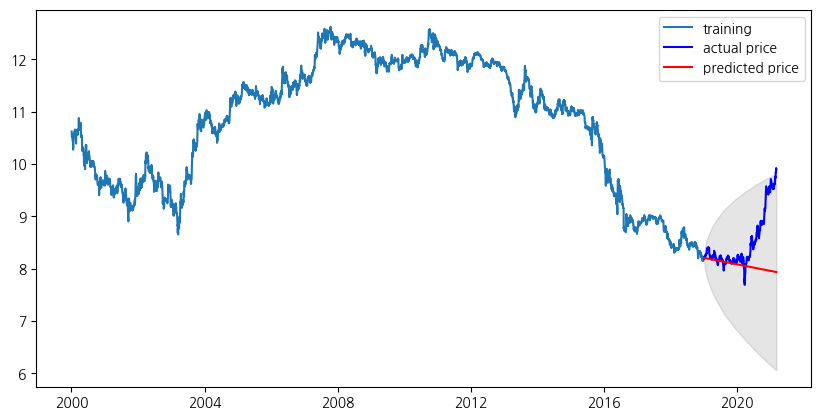

In [54]:
# Forecast : 결과가 fc에 담깁니다. 
fc03, se03, conf03 = fitted03_m.forecast(len(test03_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc03_series = pd.Series(fc03, index=test03_data.index)   # 예측결과
lower03_series = pd.Series(conf03[:, 0], index=test03_data.index)  # 예측결과의 하한 바운드
upper03_series = pd.Series(conf03[:, 1], index=test03_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train03_data, label='training')
plt.plot(test03_data, c='b', label='actual price')
plt.plot(fc03_series, c='r',label='predicted price')
plt.fill_between(lower03_series.index, lower03_series, upper03_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse03 = mean_squared_error(np.exp(test03_data), np.exp(fc03))
print('MSE: ', mse03)

mae03 = mean_absolute_error(np.exp(test03_data), np.exp(fc03))
print('MAE: ', mae03)

rmse03 = math.sqrt(mean_squared_error(np.exp(test03_data), np.exp(fc03)))
print('RMSE: ', rmse03)

mape03 = np.mean(np.abs(np.exp(fc03) - np.exp(test03_data))/np.abs(np.exp(test03_data)))
print('MAPE: {:.2f}%'.format(mape03*100))

MSE:  22894729.4161725
MAE:  2565.627863593983
RMSE:  4784.843719096007
MAPE: 27.29%


# 끝

![삼성20 03-2102](https://user-images.githubusercontent.com/59362727/109913010-89c02b80-7cf0-11eb-8274-3dc5a5af9882.png)
![테슬라20 03-21 02](https://user-images.githubusercontent.com/59362727/109913011-8a58c200-7cf0-11eb-8e8b-c751159a1961.png)
![알파벳full](https://user-images.githubusercontent.com/59362727/109913013-8af15880-7cf0-11eb-8cfd-2cebf3a57e42.png)
![HMM-20 03-2102](https://user-images.githubusercontent.com/59362727/109913015-8af15880-7cf0-11eb-998e-9c80ac02f9af.png)
![HNN_full](https://user-images.githubusercontent.com/59362727/109913016-8b89ef00-7cf0-11eb-9a54-27c80fedbc81.png)


# 프로젝트 후(위 그림참조)
삼성 1년, HMM 1년, 구글(상장 이후부터) 일 경우 어느 정도 예측을 했다. (MAPE가 10보다 작다) 반대로
HMM(상징 이후부터), 테슬라 1년 치인 경우는 예측이 빗나갔다. (MAPE가 상당히 높다) 이런 결과로 시계열 데이터 분석으로 주식을 판단하는 것은 어려운 것 같다. 노드 첫 부분에 말한 것처럼 시계열 데이터로 분석을 하기 위해서는 데이터가 안정적(stationary)이 깔려야 된다고 하였다. 특히 주식에서는 예측하지 못하는 여러 가지의 변수가 있다. 그중에서도 최근 코로나 19로 인하여 시계열 데이터분석에 대한 엄청난 변수가 있었기에 더욱 판단하기 어렵다고 생각된다. 그리고 참고로 코로나가 시작된 작년 3월에 모든 분야가 최저점을 시간이 지남에 따라 상승세를 찍고 있다. 이런 점을 본다면 지금으로부터 1년 치에 대한 MAPE은 비교적 낮을 거라는 생각이 든다. 글쓴이 같은 경우는 MAPE을 낮추기 위한 ARIMA의 변수(p,d,q) 설정보다는 시계열의 전체적인 개념을 이해하는 방향으로 노드를 진행하였다.(어렵다...)




###

# 개념

### 시계열이란
- 시간 순서대로 발생한 데이터의 수열(즉 시간순서에 따라 변하는 값들,규칙이 있을수도있고 없을수도 있고)
- 시계열 자료를 분석함에 있어, 보통 시계열이 안정적(stationary)이라는 가정이 깔려있다.


### 시계열로 미래를 예측하기위한 조건 2가지
- 과거의 데이터에 일정한 패턴이 발견된다.
- 과거의 패턴은 미래에도 동일하게 반복될 것이다    
즉 안정적(Stationary) 데이터에 대해서만 미래 예측이 가능하다.       
(안정적이라다는 의미는 시계열 데이터의 통계적 특성이 변하지 않는다.)    


### 시계열 데이터분석은 완벽하지 않다.
시계열 데이터 분석은 완벽한 미래 예측을 보장하지는 않는다. 어떤 예측하지 못한 외부적 변수에 의해 시계열 데이터 분석의 전제가 되는 안정성(stationarity)이 훼손될 여지가 있기 때문이다.   
그럼에도 시계열 데이터분석은 시간적 변화를 표현하는데 휼륭한 성능을 보인다.



### 시계열에서 안정적(Stationary)이다라는 의미
- 데이터의 통계적 특성이 변하지 않는다.
- 시계열의 평균과 분산이 시간의 흐름에 따라 체계적으로 변화하지 않는다는 것   
예로 매일변화하는 날씨같은경우 연단위로 볼때 기후 변화의 일정한 패턴이 유지될 경우,기후변화에 대한 프로세스를 만들어 내일의 날씨를 어느정도 오차범위 내에 예측할수 있을것이다.

### stationary time series(안정적 시계열)
(안정적 시계열 = 정상시계열 = 정상성 시계열)   
- 통계적인 특성이 변하지 않는 시계열을 안정적 시계열이라고 한다.
- 안정적 시계열의 시간의 추이와 관계 없이 일정한 통계적 특성은 3가지    
평균, 분산,자기공분산(autocovariance)   

﻿

### 공분산(Covariance)
- 확률변수들이 어떻게 퍼져있는지를 나타내는 것(x 편차와 Y의 편차를 곱하것의 평균)
- 분산은 하나의 변수(x)에 대한 펴져있는것을 나타낸것이고, 공분산경우는 x,y 두개 이상의 변수에 대한 분산을 구하는것

### 자기공분산(autocovariance)
자기자신을 공분산한다. 완전히 자기 자신을 공분산하는것이 아니라 h만큼 이동한 자기자신과 공분산다.즉 x, x+h의 분산을 구한다.
```
x   => 현재 자신   
x+h => 현재 자신에서 h만큼 이동한 자신
```
### 상관계수(Correlation)
- 확률 변수의 절대적 크기에 영향을 받지 않도록 단위화 시켜주는 역할함
- 공분산의 문제점을 해결하는 방법이 상관계수
- x와 y의 확률 변수가 있을때 x와 y의 변수 단위가 엄첨나게 차이가 있다면 공분산의 값은 의미가 없을것이다.
```
즉 x,y의 변수 단위에 영향을 크게 받는다
[x인 경우 만점=100, y인 경우 만점=10] 이라면 두변수간의 상관성을 직접 대표하지 못한다. 그래서 우리는 두 변수간의 상관성을 -1 ~ 1로 설정한다. 
```
https://destrudo.tistory.com/15   
https://m.blog.naver.com/PostView.nhn?blogId=sw4r&logNo=221030974616&proxyReferer=https:%2F%2Fwww.google.com%2F

### 프로젝트에서 시계열 데이터 처리 순서 
1. DataFrame에서 Date컬럼을 index로 삼는다.
2. 결측치 제거 혹은 보간 작업
 - 1)결측치가 있는 데이터를 모두 삭제(drop)하거나, 
 - 2)결측치 양옆의 값들을 이용해서 적절히 보간(interpolate) 대입해 주는 방법 사용
   판다스 보관처리 메소드 .https://rfriend.tistory.com/264
3. 원본시계열, 이동평균, 이동표준편차 시각화
4. stationary여부 체크
5. stationary한 데이터로 만들기
- 로그함수 변환
- Moving average 제거 - 추세(Trend) 상쇄하기 
- 차분(Differencing) - 계절성(Seasonality) 상쇄하기    
6. 5번단계 필요없이 ARIMA모델 활용(ARIMA모델안 알아서 데이터를 처리한다.)

### Augmented Dickey-Fuller Test(ADF Test)란 
- 시계열 데이터의 안정성을 테스트하기 사용된다.
- 이 테스트는 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후, 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다는 내용입니다.
- 즉 p-value(유의 확률)의 값이 낮을때 채택한다.

### p-value(유의확률)이란 어떤 의미인가요?
- 귀무가설이 참임에도 이를 기각할 확률()
- 귀무가설을 지지하는 정도(낮을수록 기각한다.) 

### 귀무가설
- 가설검정의 대상이 되는 가설. 귀무가설은 일반적으로 기각될 것이 예상되어 세워진 가설이고 검증하려는 가설은 귀무가설에 대해서 대립 가설 anti hypothesis로 불린다. 

### 대립가설
- 귀무가설의 반대 가설

귀무가설: 암과 흡연은 관련이 없다.

대립가설: 암과 흡연은 관련이 있다.

귀무가설은 채택될수 없고, 기각 여부만 결정된다.

귀무가설, 대립가설, 유의확률 개념참조  
https://blog.naver.com/navehag
https://m.blog.naver.com/baedical/10109291879
https://m.blog.naver.com/moses3650/221217938069

### statsmodels 패키지와 adfuller 메소드
- 현재 프로젝트에서 stationnary여부 체크할때 사용된다.
- statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지
- statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행한다.

### staionary(안정성) 하기 만드는법
- 1)정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형한다.

- 2)시계열 분해(Time series decomposition)라는 기법을 적용
    
    
- 안정성이다라면  p-value(유의 확률)이 낮아진다. 즉 귀무가설 값들이 많이 기각되었다.

- 로그화 변환

### 이동평균 (MA, Moving Average)= 롤링산술평균(Rolling Mean)
- 이동 평균은 moving average, rolling average, rolling mean 또는 running average라고 한다.
- 지정된 간격 안에서 노드 평균을 계산하는 데 사용합니다. 간격 크기가 3으로 설정된 경우 현재 노드와 앞의 두 노드를 사용하여 평균이 계산됩니다. 이동 평균을 사용하는 목적은 일반적으로 단기 변동을 평준화하고 장기 동향을 파악하는 것입니다.
https://docs.tibco.com/pub/spotfire_web_player/6.0.0-november-2013/ko-KR/WebHelp/GUID-5A18B4F1-8465-4200-881A-8721BF1A48B1.html


- 이동평균은 시계열 데이터 내의 잡음(noise)을 제거하는 데이터 전처리, 혹은 계절성이 존재하는 시계열 데이터에서 계절성 부분을 빼고 장기 추세 요인(trend factor)나 중기 순환/주기 요인(cycle factor)를 보려고 할 때 많이 사용합니다. 시계열 데이터 예측(forecasting)에도 사용한다.    
https://rfriend.tistory.com/502 


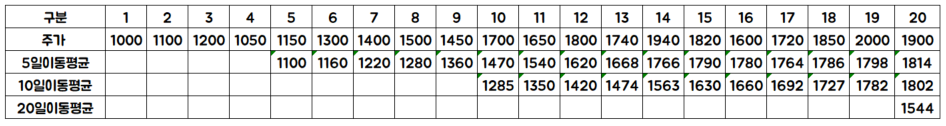

https://paultrader.tistory.com/24

### rolling(window=12).mean() 의미는?
- 11번까지는 NAN나옴 12번째는 1 ~ 12번째 평균, 13번째는 2 ~ 13번째 평균, 14번째는 3 ~ 14번째 평균 이렇게 끝까지 평균을 내는것을 이동평균이라고 한다.
- moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다는 것을 기억해 둡시다

### 그림의 의미는 무엇인가?
```
파란색은 trend(추세)
빨간색은 MA, Moving Average(이동평균)
```

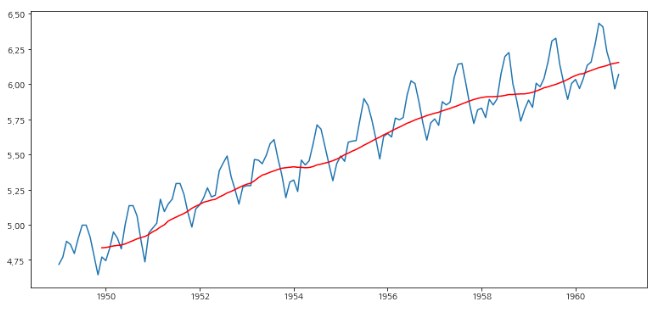

ts_log_moving_avg = ts_log - moving_avg # 변화량 제거    
ts_log_moving_avg = 트렌드 - 빨강색(MA)    
위와 같은 방식으로 변화량 제거한다고 한다.
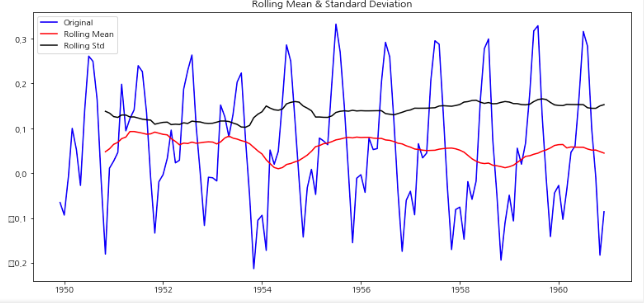

### 주기적 패턴- 계절성(Seasonality)
- Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다.
- Moving Average 제거로 상쇄되지 않는 요소

### 차분(Differencing)
- 예측에 방해 되는 주기적 패턴의 계절성을 제거해준다.
- 현재 스텝 값 - 직전 스텝 값

- 직전이 파란색, 현재가 녹색
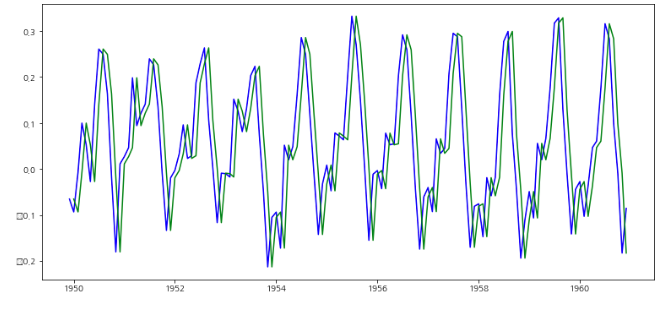

### 시계열 분해(Time series decomposition)
Trend+Seasonality+Residual=Original 식에서  Residual뽑아 내어 시계열 데이터를 예측한다.?

### ARIMA 모델
- ARIMA(Autoregressive Integrated Moving Average)
- ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)가 합쳐진 모델
- 자세한 설명
https://otexts.com/fppkr/non-seasonal-arima.html

#### AR(자기회귀, Autoregressive)
- AR은 일반적인 시계열에서 Trend와 Seasonality를 제거한 Residual에 해당하는 부분을 모델링한다고 볼 수 있다.
- 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이 바로 주식 시계열을 AR로 모델링하는 관점


#### MA(이동평균, Moving Average)
- 위에서 언급했으니 생략

#### I (차분누적, Integration)
- AR[주식값이 떨어졌을때,다음엔 주식이 올라가 균형을 맞추겠지]과 MA[주식값이 떨어졌으니 지속적으로 떨어지겠네?]의 우려를 동시에 생각한다. ARIMA는 이 두 모델 사이에서 적정 가중치를 찾아가는 휠씬 통합적인 예측 능력을 보여준다.

### ARIMA 모델의 모수 p, q, d
- 시계열 예측 모델을 성공적으로 만들기 위해서는 ARIMA의 모수(parameter)를 데이터에 맞게 설정해야 한다.
```
 자기회귀 모형(AR) 시차   =>  p
 차분(diffdrence) 횟수  =>  d
 이동평균 모형(MA)의 시차  =>  q
```

모수 p,d,q는 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)을 통해 결정할수 있다.

이 ACF와 PACF는 (자기)상관계수와 같은 개념이다.

### 자기상관이란? (Autocorrelation) 
- ACF  (Autocorrelation Function)
- ACF 는 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수 

### 편자기상관(PACF, Partial AutoCorrelation)
- PACF (Partial AutoCorrelation Function)
- PACF 는 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수


### 시차(time lag)란
- 특정 기간의 결과가 이후의 기간에 영향을 끼치는 경우
- 시점과 시점사이의 거리 + 그 사이의 변화
https://blog.naver.com/navehag

### AR/MA모형과 ACF/PACF 관계

ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있다.
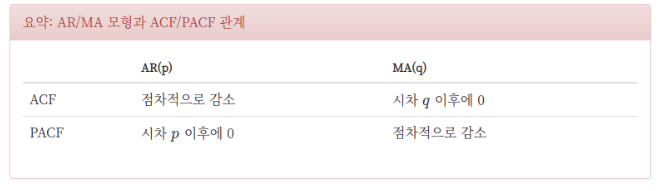

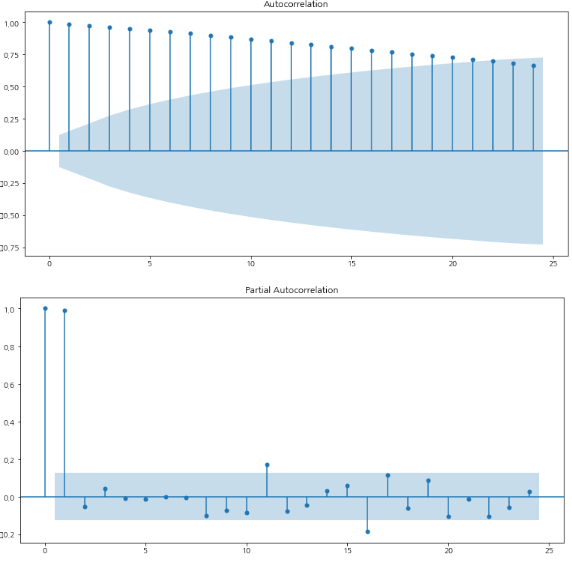

### ARIMA모델에서 (p,d,q) 값 변경
각 변수의 상호간 관계를 파악하면 설정하는 방법을 모르겠다. 나중에 시계열데이터를 다른다고 하면 그때 자세히 공부해보자.

# 코드


#### 1.Series 무엇인가?
Pandas에서 제공하는 Series라는 자료구조

#### 2.  날짜를 인덱스로 설정하는법
https://soo-jjeong.tistory.com/127    
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True      
parse_dates는 날짜를 datetime형태로 변환할지 여부     
index_col는 날짜칼럼을 인덱스로 설정하기 위한 것

#### 3. Series자료형 결측치 찾기
ts1[ts1.isna()]     
https://hogni.tistory.com/72

#### 4. Series자료형에 결측치 있는 경우 보간방식 사용
  ( 1과 3 사이에 결측치가 존재한다면 2로 정해준다.)     
ts1.interpolate(method='time') # 보간 기준은 time을 선택

#### 5.def plot_rolling_statistics(timeseries, window=12)
일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수입니다. 현재 타임스텝부터 window에 주어진 타임스텝 이전 사이 구간의 평균(rolling mean, 이동평균)과 표준편차(rolling std, 이동표준편차)를 원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인한다.

#### 6. statsmodels 라이브러리 안에는 seasonal_decompose 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다.